In [30]:
import numpy as np  
import matplotlib.pyplot as plt 
import scipy.signal as sp
import numpy.linalg as nplin
from gekko import GEKKO

from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.signal import place_poles
from scipy.signal import find_peaks
from scipy.linalg import solve_continuous_are


from plotfunc import plot_sets

In [6]:
R=0.5
L=0.2
C=0.5

A=np.array([[0,1],[-1/(L*C),-R/L]])
B=np.array([[0],[1/L]])

Q=np.array([[1,0],
            [0,1]])

R=np.array([[1]])

P = solve_continuous_are(A, B, Q, R)

print(f"Macierz P:")
print(P)

Macierz P:
[[1.59270823 0.0472136 ]
 [0.0472136  0.13189887]]


In [7]:
R_inv = np.linalg.inv(R) # Odwrotność macierzy R
K = R_inv @ B.T @ P

print("\nMacierz Wzmocnień K:")
print(K)


Macierz Wzmocnień K:
[[0.23606798 0.65949437]]


In [8]:
def model(x,t):
    R=0.5
    L=0.2
    C=0.5
    u=np.array([[1]])

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])

    dx=A@x+(B*u).flatten()
    return dx

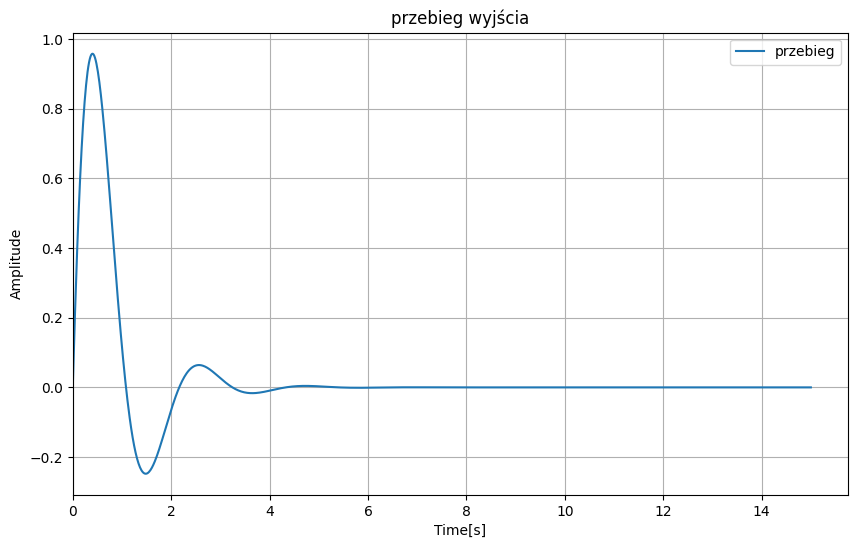

In [9]:
x0 = np.array([0, 0])

t = np.linspace(0, 15, 1000)

x = odeint(model, x0, t)

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [10]:
def model_with_K(x,t,K):
    R=0.5
    L=0.2
    C=0.5
    u=-K@x

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])
    
    dx=A@x+(B*u).flatten()
    return dx

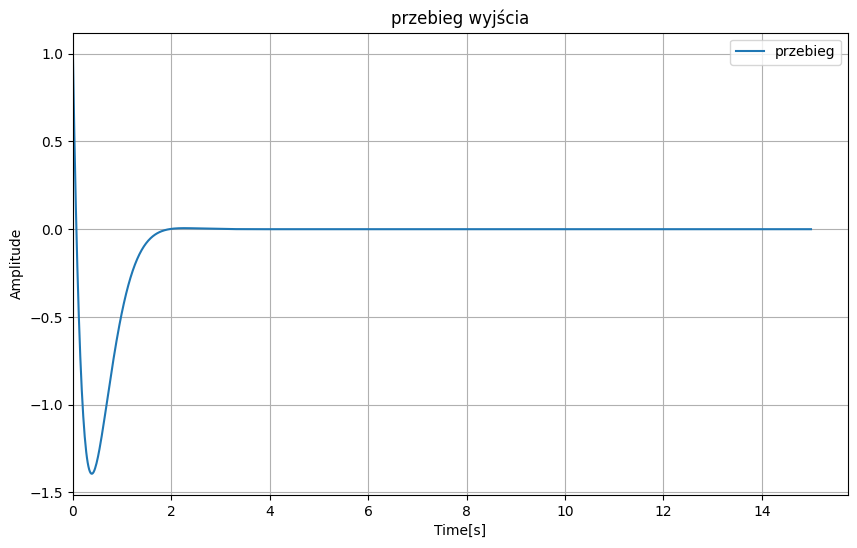

In [11]:
x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x = odeint(model_with_K, x0, t,args=(K,))

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [12]:
R1=np.array([[1]]) #"koszt" energetyczny 
Q1=np.array([[10,0], #"koszt" stanu 
             [0,10]])

P1 = solve_continuous_are(A, B, Q1, R1)
R1_inv = np.linalg.inv(R1) 
K1 = R1_inv @ B.T @ P1

R2=np.array([[10]])
Q2=np.array([[1,0],
             [0,1]])

P2 = solve_continuous_are(A, B, Q2, R2)
R2_inv = np.linalg.inv(R2) 
K2 = R2_inv @ B.T @ P2

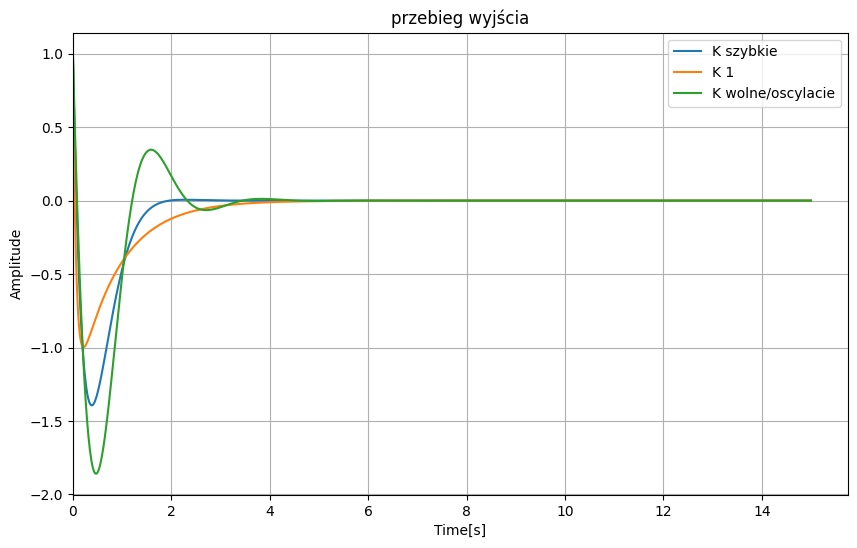

In [13]:

x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x1 = odeint(model_with_K, x0, t,args=(K,))
x2=odeint(model_with_K, x0, t,args=(K1,))
x3=odeint(model_with_K, x0, t,args=(K2,))


y1 = x1[:, 1]
y2 = x2[:, 1]
y3 = x3[:, 1]

plot_sets('przebieg wyjścia',[t,y1,'K szybkie'],
          [t,y2,'K 1'],
          [t,y3,'K wolne/oscylacie'])

In [14]:
A = np.array([[0.0, 1.0], [-10.0, -2.5]])
B = np.array([[0.0], [5.0]])

def model_cost_function(x_roz, t, K, Q, R_wag):
    # Krok 1: Wydobycie stanu nominalnego (x)
    x = x_roz[:2] 
    x_vec = x.reshape(2, 1) # Kolumnowy wektor stanu (2x1)

    # Krok 2: Sygnał sterujący (u)
    # u = -Kx (skalar)
    u = -K @ x 
    u_mat = np.array([[u]]) # Macierz 1x1 dla u

    # Krok 3: Obliczenie pochodnych stanu nominalnego (x_dot)
    # x_dot = A@x + B@u
    x_dot_nominal_matrix = A @ x_vec + B @ u_mat
    
    # Krok 4: Obliczenie wyrażenia podcałkowego J_dot
    # J_dot = x^T * Q * x + u^T * R_wag * u
    cost_integrand = x_vec.T @ Q @ x_vec + u_mat.T @ R_wag @ u_mat
    
    
    # x_dot_nominal musi być spłaszczony do wektora 1D, aby konkatenacja była poprawna
    x_dot_nominal = x_dot_nominal_matrix.flatten() 
    cost_flat = cost_integrand.flatten()
    
    return np.concatenate((x_dot_nominal, cost_flat))

In [16]:
x0 = np.array([1, 1, 0])

t = np.linspace(0, 15, 1000)

R_w=np.array([[1]])

sol_LQR = odeint(model_cost_function, x0, t, args=(K, Q, R_w))
J_LQR = sol_LQR[-1, 2] # Wartość J_akum w ostatniej chwili

# Symulacja dla innych wzmocnień (nieoptymalne)
sol_Inne = odeint(model_cost_function, x0, t, args=(K1, Q1, R1))
J_Inne = sol_Inne[-1, 2]

sol_Inne2 = odeint(model_cost_function, x0, t, args=(K1, Q2, R2))
J_Inne2 = sol_Inne2[-1, 2]

print(f"Wartość wskaźnika J dla wzmocnień LQR: {J_LQR:.4f}")
print(f"Wartość wskaźnika J dla innych wzmocnień: {J_Inne:.4f}")
print(f"Wartość wskaźnika J dla innych wzmocnień: {J_Inne2:.4f}")

Wartość wskaźnika J dla wzmocnień LQR: 1.8190
Wartość wskaźnika J dla innych wzmocnień: 12.6379
Wartość wskaźnika J dla innych wzmocnień: 15.1932


# 3 skonczony horyzont czasowy 


In [18]:
A = np.array([[0.0, 1.0], [-10.0, -2.5]])
B = np.array([[0.0], [5.0]])

Q = np.eye(2)
R = np.array([[1.0]]) 
R_inv = np.linalg.inv(R)

def riccati(p,t):
    P=p.reshape((2, 2))

    P_dot = (P@A-P@B@R_inv@B.T@P+A.T@P+Q)*-1

    p_dot = P_dot.flatten()

    return p_dot

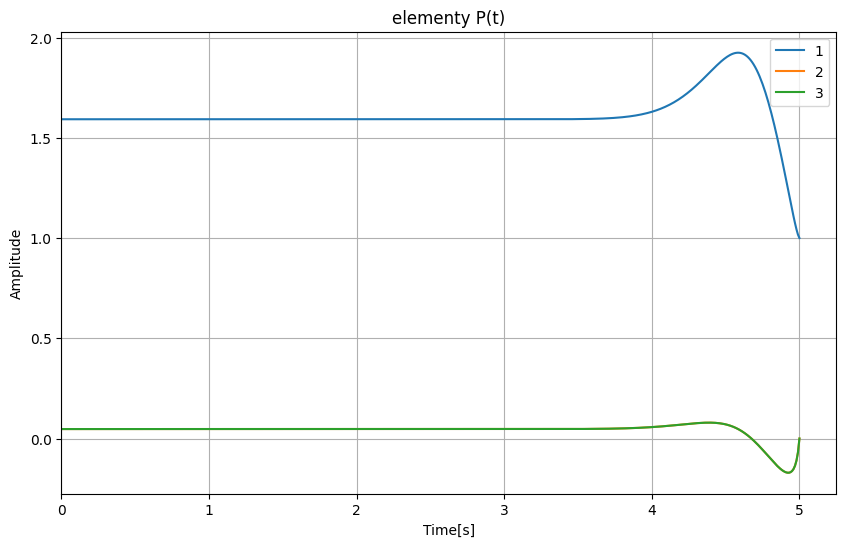

In [26]:
S = np.eye(2)
p0 = S.flatten()

t_r = np.arange(5,0,-0.01)

sol_riccati = odeint(riccati, p0, t_r)

P_t = sol_riccati

P_t_reversed = P_t[::-1] 
t_reversed = t_r[::-1]

plot_sets("elementy P(t)",[t_reversed,P_t_reversed[:,0],"1"],[t_reversed,P_t_reversed[:,1],"2"],[t_reversed,P_t_reversed[:,2],"3"])


In [31]:
A = np.array([[0.0, 1.0], [-10.0, -2.5]])
B = np.array([[0.0], [5.0]])

P_interp_P11 = interp1d(t_reversed, P_t_reversed[:, 0], kind='linear', fill_value='extrapolate')
P_interp_P12 = interp1d(t_reversed, P_t_reversed[:, 1], kind='linear', fill_value='extrapolate')
P_interp_P22 = interp1d(t_reversed, P_t_reversed[:, 3], kind='linear', fill_value='extrapolate')

def get_P_t(t):
    P11 = P_interp_P11(t)
    P12 = P_interp_P12(t)
    P22 = P_interp_P22(t)
    # Macierz P musi być symetryczna
    return np.array([[P11.item(), P12.item()], [P12.item(), P22.item()]])


def model_FTH(x_roz, t):
    # Krok 1: Wydobycie stanu nominalnego (x)
    x = x_roz[:2] 
    x_vec = x.reshape(2, 1) # Kolumnowy wektor stanu (2x1)

    P_t = get_P_t(t)

    K_t= K_t = R_inv @ B.T @ P_t
    
    u = -K @ x 
    u_mat = np.array([[u]]) 

    x_dot_nominal_matrix = A @ x_vec + B @ u_mat
    
    x_dot_nominal = x_dot_nominal_matrix.flatten() 
    
    return x_dot_nominal